In [1]:
%reload_ext autoreload
%autoreload 2
import tie.dbutils as db
import tie.utils as qa
import pandas as pd
from scipy.io import savemat, loadmat
import json
from tqdm import tqdm
import os
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import DivergingNorm, TwoSlopeNorm, Normalize
from statsmodels.stats.multitest import fdrcorrection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

In [2]:
rc('font', **{'family':'sans-serif',
              'sans-serif':['Helvetica']})
FONT_SIZE = 25
params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE}
matplotlib.rcParams.update(params)

ORDER = [0, 2, 3, 1] # Full, Social, Transition, Launcher

In [3]:
study_id_1 = 'aef31aeb7b4d9dde43779738b42be454dc0ede19'  # -- Leiden Uni Age Study
study_id_2 = "aef333cc3597c660421091c3f4d8ecb4e809de19" # -- Leiden Uni 
study_id_3 = "aef34cc4d24c162f4f87becb74515e392560de19" # -- COOLS

In [4]:
raw_query = '''SELECT SDV."partId", SDV."devicePartId" as "devPartId", tde."deviceInfo", tde."id", "modified", "created"
from "StudyDetailsView" SDV
JOIN "TapDevice" tde on SDV."tapDeviceId" = tde."id"
where SDV."studyId"=? or SDV."studyId"=? or SDV."studyId"=?;'''
df = db.raw_query(raw_query, params=[study_id_1, study_id_2, study_id_3])
df['days'] = (df['modified'] - df['created'] ) / 1000 / 3600 / 24
df.head()

,partId,devPartId,deviceInfo,id,modified,created,days
0,138efc8063d3729040fb817663edae7c94b328eb,8sd8fe9d359d9d654c7fafb8efc55def56dc12ka,"{""androidVersion"":""9"",""deviceManufacturer"":""On...",0032fe57-d169-4a43-919d-bd415de40a8e,1592896678076,1587754338923,59.517814
1,138ee12eb779c05544cba2bfee03ecef1feb28eb,8sd8a4534d5635cb4936a9d848e019dfa68f12ka,"{""androidVersion"":""9"",""deviceManufacturer"":""mo...",00431dfe-0245-47fe-879e-e641daa55dc9,1568805227286,1565089811972,43.002492
2,138ed0875390f3a9481b91008ce91afd311b28eb,8sd8487d5cd6bf2641fcb010f356b3ca764612ka,"{""androidVersion"":""10"",""deviceManufacturer"":""s...",004bd8e1-6d85-4c22-9237-e3cbf03c8b34,1619572040879,1605953944009,157.616862
3,138eeebb218939064b0b89dc57becec13e2628eb,8sd83350e85a31904c3f9063cdb10c86ee2f12ka,"{""androidVersion"":""7.0"",""deviceManufacturer"":""...",006113f7-d8c6-47ac-a661-217ccf79716d,1620632375106,1591129258617,341.471256
4,138e6a50842053664fc4b61fc8b948661d3c28eb,8sd821098b72ea0145d1aef3444019d7193012ka,None,013bce72-3906-42b0-a72f-404c7702e55e,1549096732630,1549096731345,0.000015


In [5]:
info_age = pd.read_csv('../../only_info_age_gender.csv')
full_info = info_age.merge(df, on='partId').dropna().drop_duplicates("partId")
full_info.head()

,partId,age,n_taps,gender,devPartId,deviceInfo,id,modified,created,days
0,138ee6d165fa06954ba1bed56719415b12dd28eb,60,2297021,2,8sd8474d8c7c03ef46c5b3acf034d689257c12ka,"{""androidVersion"":""11"",""deviceManufacturer"":""s...",9feae480-d169-486e-b00d-02fcf4585d44,1624864230891,1593108388846,367.544468
2,138ee5b320ea6ee948d2a3bf2f8c55ffecd428eb,23,339201,2,8sd8762e35b65efa465fb90c7d2b7f5b5ad012ka,"{""androidVersion"":""10"",""deviceManufacturer"":""s...",f23fd700-1d72-4db0-a584-e7f979ad6d92,1620035028533,1593642422788,305.469974
3,138ee5990d0a29304d079d1d96be414edbd528eb,38,9978,2,8sd893adaedee50e43cd8266a64b5f56847912ka,"{""androidVersion"":""8.0.0"",""deviceManufacturer""...",63926912-6474-4db4-b7ce-882e9c1c4cad,1594490917748,1593769811395,8.346138
4,138efc29c56fa8b346a18aab7b0dd3ae6fe928eb,29,734487,2,8sd8ad0f165359b04ff8a60b8016ec6833d812ka,"{""androidVersion"":""11"",""deviceManufacturer"":""s...",d6c64710-9ffe-4c84-ba9a-7899bdab5619,1624864433670,1587804654554,428.932629
5,138ef569f2dd6a1d4e0e935c88bee242e73a28eb,40,31362,1,8sd86a87c4ebdce9477fbff92d529689c75012ka,"{""androidVersion"":""6.0.1"",""deviceManufacturer""...",9c053841-41a2-4a32-8716-e7f1bb934fc9,1624471244915,1589271873691,407.400130


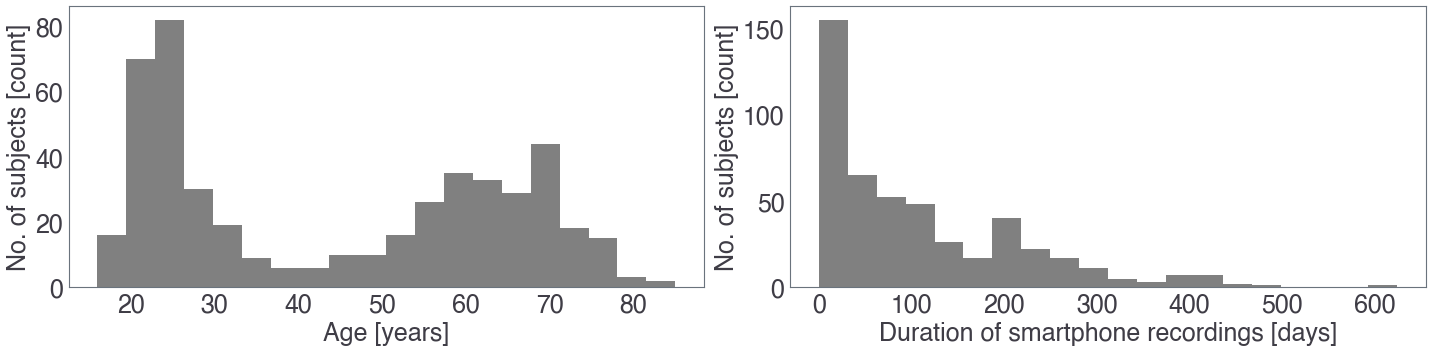

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

## AGE
# full_info[full_info["age"] < 20]["age"].hist(bins=np.linspace(0, 20, 10), ax=ax[0])
# full_info[(full_info["age"] >= 20) & (full_info["age"] < 40)]["age"].hist(bins=np.linspace(20, 40, 10), ax=ax[0])
# full_info[(full_info["age"] >= 40) & (full_info["age"] < 60)]["age"].hist(bins=np.linspace(40, 60, 10), ax=ax[0])
# full_info[full_info["age"] >= 60]["age"].hist(bins=np.linspace(60, 100, 20), ax=ax[0])
full_info["age"].hist(bins=20, ax=ax[0], color='grey')

ax[0].set_xlabel("Age [years]")
ax[0].set_ylabel("No. of subjects [count]")
ax[0].grid(False)

## DAYS
# full_info[full_info["days"] < 90]["days"].hist(bins=np.linspace(0, 90, 5), ax=ax[1])
# full_info[(full_info["days"] >= 90) & (full_info["days"] < 180)]["days"].hist(bins=np.linspace(90, 180, 5), ax=ax[1])
# full_info[(full_info["days"] >= 180) & (full_info["days"] < 365)]["days"].hist(bins=np.linspace(180, 365, 10), ax=ax[1])
# full_info[full_info["days"] >= 365]["days"].hist(bins=np.linspace(365, 545, 10), ax=ax[1])
full_info["days"].hist(bins=20, ax=ax[1], color='grey')

ax[1].set_xlabel("Duration of smartphone recordings [days]")
ax[1].set_ylabel("No. of subjects [count]")
ax[1].grid(False)

plt.tight_layout()
plt.savefig('figure_1_panel_a.pdf', transparent=True)

In [7]:
print(f"No. subjects {len(full_info)}, {len(full_info[full_info['gender'] == 2])} females")

print(f"Min(Age) = {min(full_info['age'])} | Max(Age) = {max(full_info['age'])} | 25th(Age) = {np.percentile(full_info['age'], 25)} | 50th(Age) = {np.percentile(full_info['age'], 50)} | 75th(Age) = {np.percentile(full_info['age'], 75)}")
print(f"Min(days) = {min(full_info['days']):.0f} | Max(days) = {max(full_info['days']):.0f} | 25th(days) = {np.percentile(full_info['days'], 25):.0f} | 50th(days) = {np.percentile(full_info['days'], 50):.0f} | 75th(days) = {np.percentile(full_info['days'], 75):.0f}")

No. subjects 479, 289 females
Min(Age) = 16 | Max(Age) = 85 | 25th(Age) = 24.0 | 50th(Age) = 45.0 | 75th(Age) = 63.0
Min(days) = 0 | Max(days) = 624 | 25th(days) = 19 | 50th(days) = 79 | 75th(days) = 172


# Panel b

In [8]:
allJIDs = loadmat('ex_all_jids.mat')

In [9]:
fullJID = allJIDs['fullJID']
socialJID = allJIDs['socialJID']
launcherJID = allJIDs['launcherJID']
transitionJID = allJIDs['transitionJID']
print(fullJID.shape)

(50, 50)


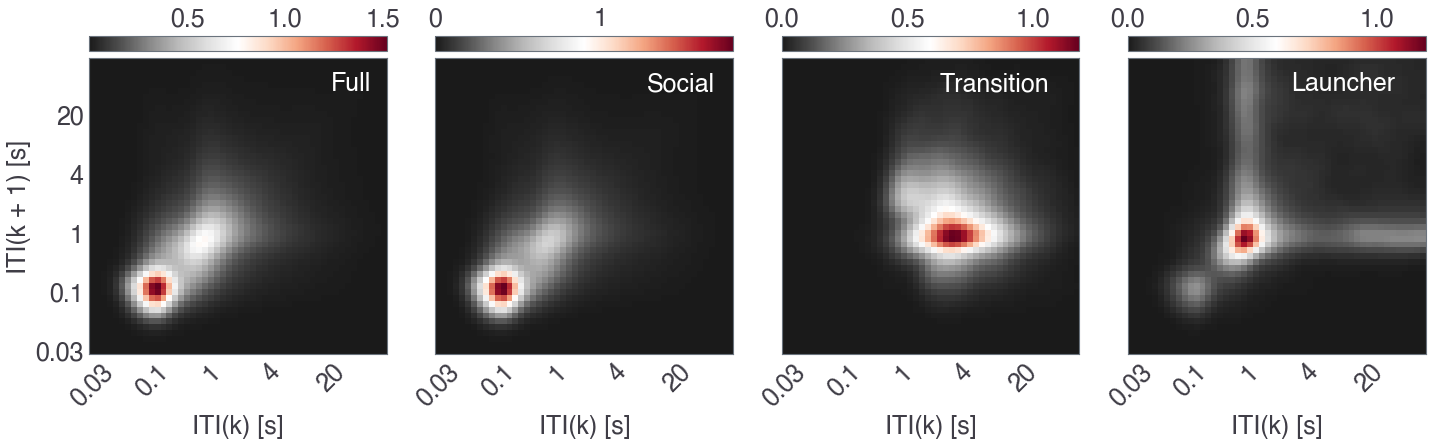

In [10]:
# This is over 166 days
fig, ax = plt.subplots(1, 4, figsize=(20, 6.3), sharey=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

for i, (_JID, _title, x_bias) in enumerate(zip([fullJID, socialJID, transitionJID, launcherJID], 
                             ['Full', 'Social', 'Transition', 'Launcher'],
                             [40, 35, 26, 27])):
    im = ax[i].imshow(_JID.T, aspect='auto', cmap='RdGy_r')
    ax[i].text(x_bias, 44, f"{_title}", fontsize=25, color='white')
    ax[i].invert_yaxis()
    ax[i].set_xticks(ticks)
    ax[i].set_xticklabels(labels)
    ax[i].xaxis.set_tick_params(rotation=45)
    ax[i].set_yticks(ticks)
    ax[i].set_yticklabels(labels)
    ax[i].set_xlabel('ITI(k) [s]')
    ax[i].grid(False)
    divider = make_axes_locatable(ax[i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
ax[0].set_ylabel('ITI(k + 1) [s]');
plt.tight_layout()
plt.savefig('figure_1_panel_b.pdf', transparent=True)

# Panel c

In [11]:
all_age_res = loadmat('../../all_age_gender_log_v5_IRLS.mat')['all_age_gender'][0]  # 4 structs for 4 JIDs

In [18]:
data_it = all_age_res[2].flat[0][0].flat[0]
A = data_it[3].squeeze().reshape(-1, 50, 50).T
print(A.shape)
B = data_it[4].squeeze()
print(B.shape)

(50, 50, 411)
(411, 3)


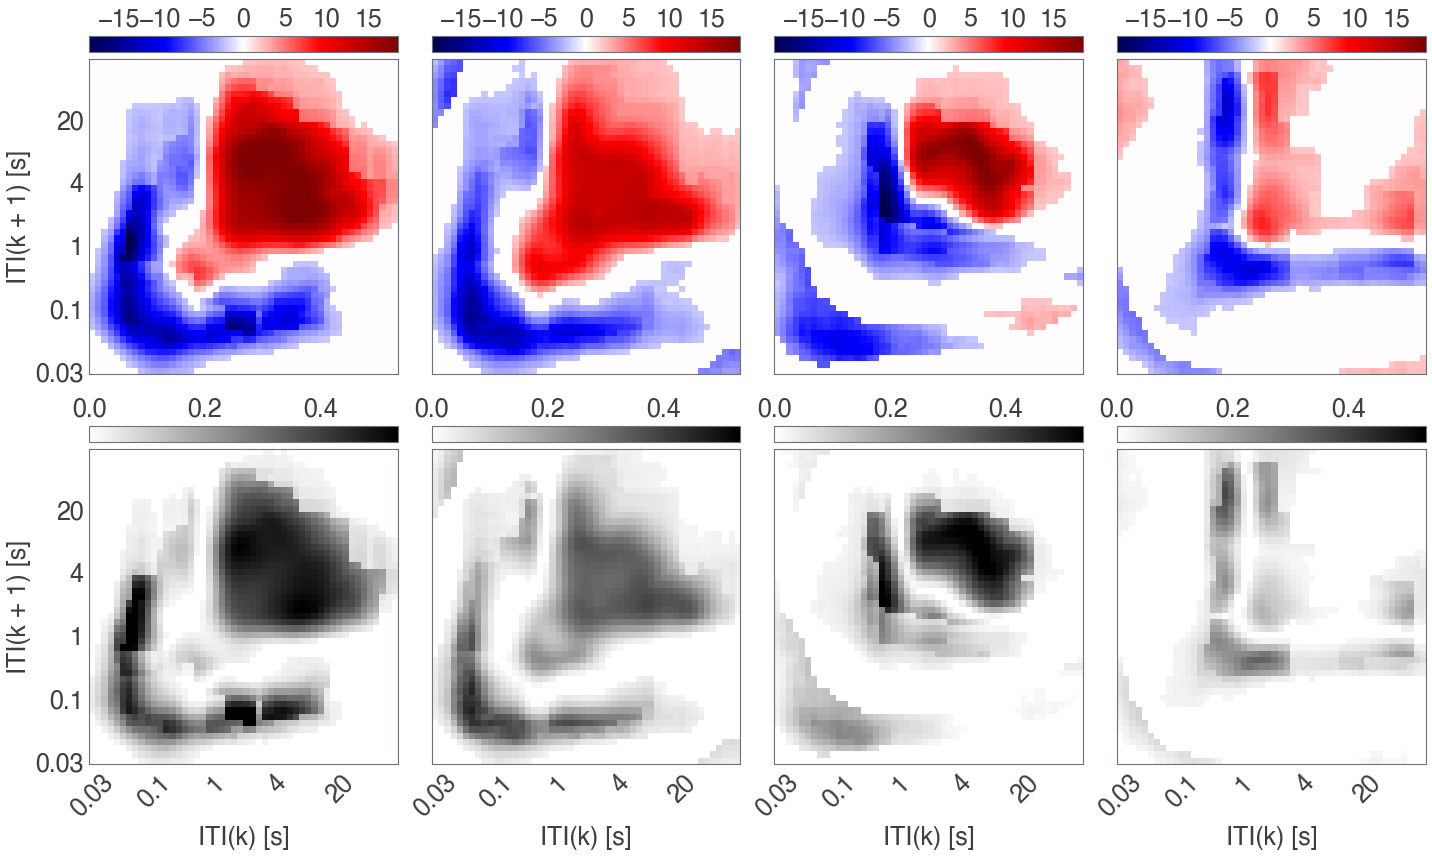

In [22]:
fig, ax = plt.subplots(2, 4, figsize=(20, 12), sharey=True, sharex=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(4):
    data_it = all_age_res[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]


    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    vmax_f = max(vmax_f, np.percentile(np.sqrt(square_f) * np.sign(k), 99))
    vmin_f = min(vmin_f, np.percentile(np.sqrt(square_f) * np.sign(k), 1))
    
    vmax_r = max(vmax_r, np.percentile(r2_full, 99))
    vmin_r = min(vmin_r, np.percentile(r2_full, 1))

tval_max = max([vmax_f, -vmin_f])

for i, _title in enumerate(['Full', 'Social', 'Transition', 'Launcher']):

    data_it = all_age_res[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]
        

    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    im = ax[0][i].imshow(np.sign(masks_uni[0]) * np.sqrt(square_f) * np.sign(k), aspect='auto', 
                         cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=-tval_max, vmax=tval_max))

    ax[0][i].invert_yaxis()
    ax[0][i].set_xticks(ticks)
    ax[0][i].set_xticklabels(labels)
    ax[0][i].xaxis.set_tick_params(rotation=45)
    ax[0][i].set_yticks(ticks)
    ax[0][i].set_yticklabels(labels)
#     ax[0][i].set_xlabel('ITI(k) [s]')
    ax[0][i].grid(False)
    divider = make_axes_locatable(ax[0][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    

    im = ax[1][i].imshow(np.sign(mask_full) * square_r2_full, aspect='auto', cmap='binary', 
                            interpolation='none', norm=Normalize(0, vmax=vmax_r * 0.99))
    ax[1][i].invert_yaxis()
    ax[1][i].set_xticks(ticks)
    ax[1][i].set_xticklabels(labels)
    ax[1][i].xaxis.set_tick_params(rotation=45)
    ax[1][i].set_yticks(ticks)
    ax[1][i].set_yticklabels(labels)
    ax[1][i].set_xlabel('ITI(k) [s]')
    ax[1][i].grid(False)
    divider = make_axes_locatable(ax[1][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     _t = cb.set_ticks(np.arange(0.0, max(_t) + .1, .2))
    
ax[0][0].set_ylabel('ITI(k + 1) [s]');
ax[1][0].set_ylabel('ITI(k + 1) [s]');
    
plt.tight_layout()
plt.savefig('figure_1_panel_c.pdf', transparent=True)

#### Supplementary 2

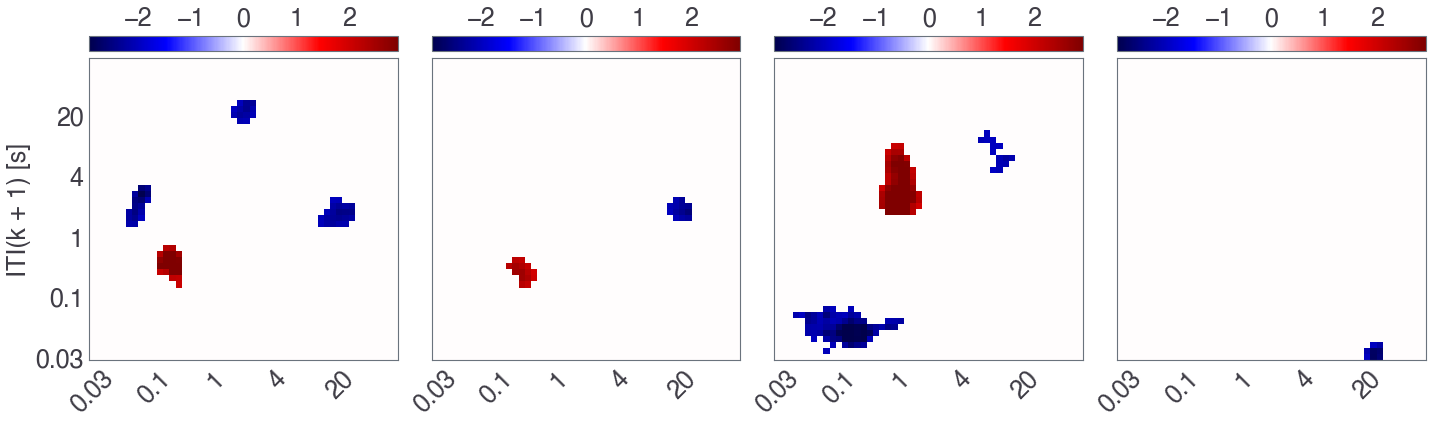

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6), sharey=True, sharex=True)
    
labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(4):
    data_it = all_age_res[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]
        

    k = betas[:, 1].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 1].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    vmax_f = max(vmax_f, np.percentile(np.sqrt(square_f) * np.sign(k), 99))
    vmin_f = min(vmin_f, np.percentile(np.sqrt(square_f) * np.sign(k), 1))
    
    vmax_r = max(vmax_r, np.max(r2_full))
    vmin_r = min(vmin_r, np.min(r2_full))

tval_max = max([vmax_f, -vmin_f])

for i, _title in enumerate(['Full', 'Social', 'Transition', 'Launcher']):

    data_it = all_age_res[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]
        
    k = betas[:, 1].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 1].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    im = ax[i].imshow(np.sign(masks_uni[1]) * np.sqrt(square_f) * np.sign(k), aspect='auto', 
                         cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=-tval_max, vmax=tval_max))

    ax[i].invert_yaxis()
    ax[i].set_xticks(ticks)
    ax[i].set_xticklabels(labels)
    ax[i].xaxis.set_tick_params(rotation=45)
    ax[i].set_yticks(ticks)
    ax[i].set_yticklabels(labels)
    ax[i].grid(False)
    divider = make_axes_locatable(ax[i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()

ax[0].set_ylabel('ITI(k + 1) [s]');
ax[0].set_ylabel('ITI(k + 1) [s]');
plt.tight_layout()
plt.savefig('figure_1_supplementary_ii.pdf', transparent=True)

# Panel d

<ipython-input-24-4fca3cad4659>:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


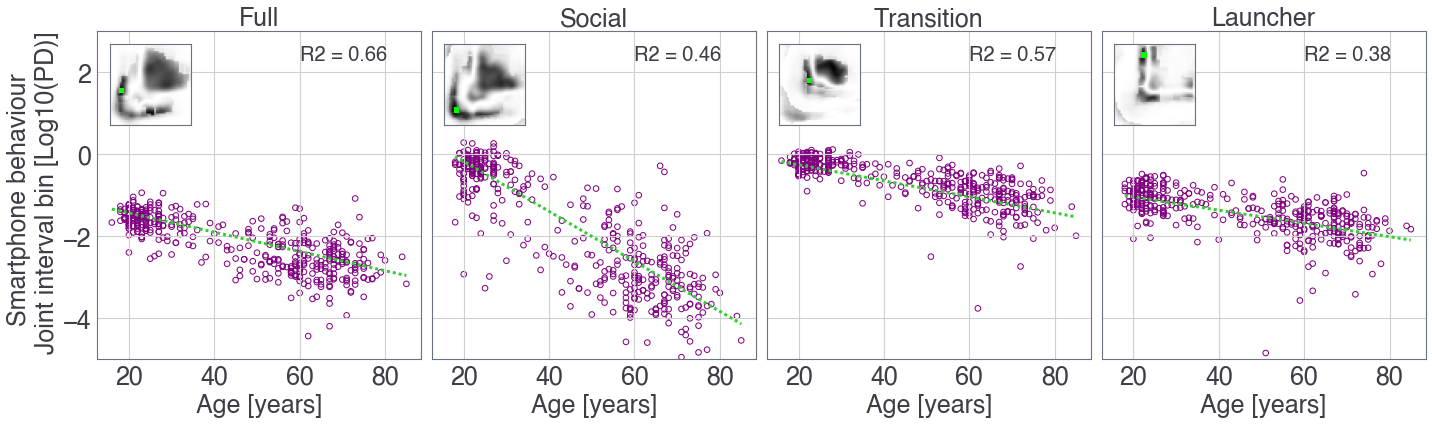

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6), sharey=True, sharex=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

for i, _title in enumerate(['Full', 'Social', 'Transition', 'Launcher']):
    
    data_it = all_age_res[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    A = data_it[3].squeeze()
    B = data_it[4].squeeze()
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]
        
    
    idx = np.argmax(r2_full)
    _y = A[:, idx]
    _x = B[:, 0]
    _k = betas[idx]
    
    ax[i].scatter(_x, _y, facecolors='none', edgecolors='purple', label='Subjects', linewidth=1)
    ax[i].plot([_x.min(), _x.max()], np.array([_x.min(), _x.max()]) * _k[0] + _k[2], 'limegreen', dashes=[1, 1], linewidth=3, label="Linear Fit")
    
    ax[i].set_ylim([-5, 3])
    ax[i].set_title(_title)
    ax[i].set_xlabel("Age [years]")

    ax[i].text(60, 2.3, f"R2 = {r2_full[idx]:.2f}", fontsize=20)
    
    inset_ax = inset_axes(ax[i],
                          height="25%", # set height
                          width="25%", # and width
                          loc='upper left') # center, you can check the different codes in plt.legend?
    inset_ax.imshow(r2_full.reshape(50, 50).T, cmap='binary')
    inset_ax.xaxis.set_visible(False)
    inset_ax.yaxis.set_visible(False)
    inset_ax.grid(False)
    inset_ax.invert_yaxis()
    x1 = idx % 50
    y1 = idx // 50;
    rect1 = matplotlib.patches.Rectangle((y1, x1), 2, 2, linewidth=2, edgecolor='lime', facecolor='lime')
    inset_ax.add_patch(rect1)
    
ax[0].set_ylabel("Smartphone behaviour \n Joint interval bin [Log10(PD)]");
plt.tight_layout()
plt.savefig("figure_1_panel_d.pdf", transparent=True)

# Supplementary

## S1

In [25]:
all_age_entropy = loadmat('../../adjusted_entropy_response.mat')['all_adjusted'][0]

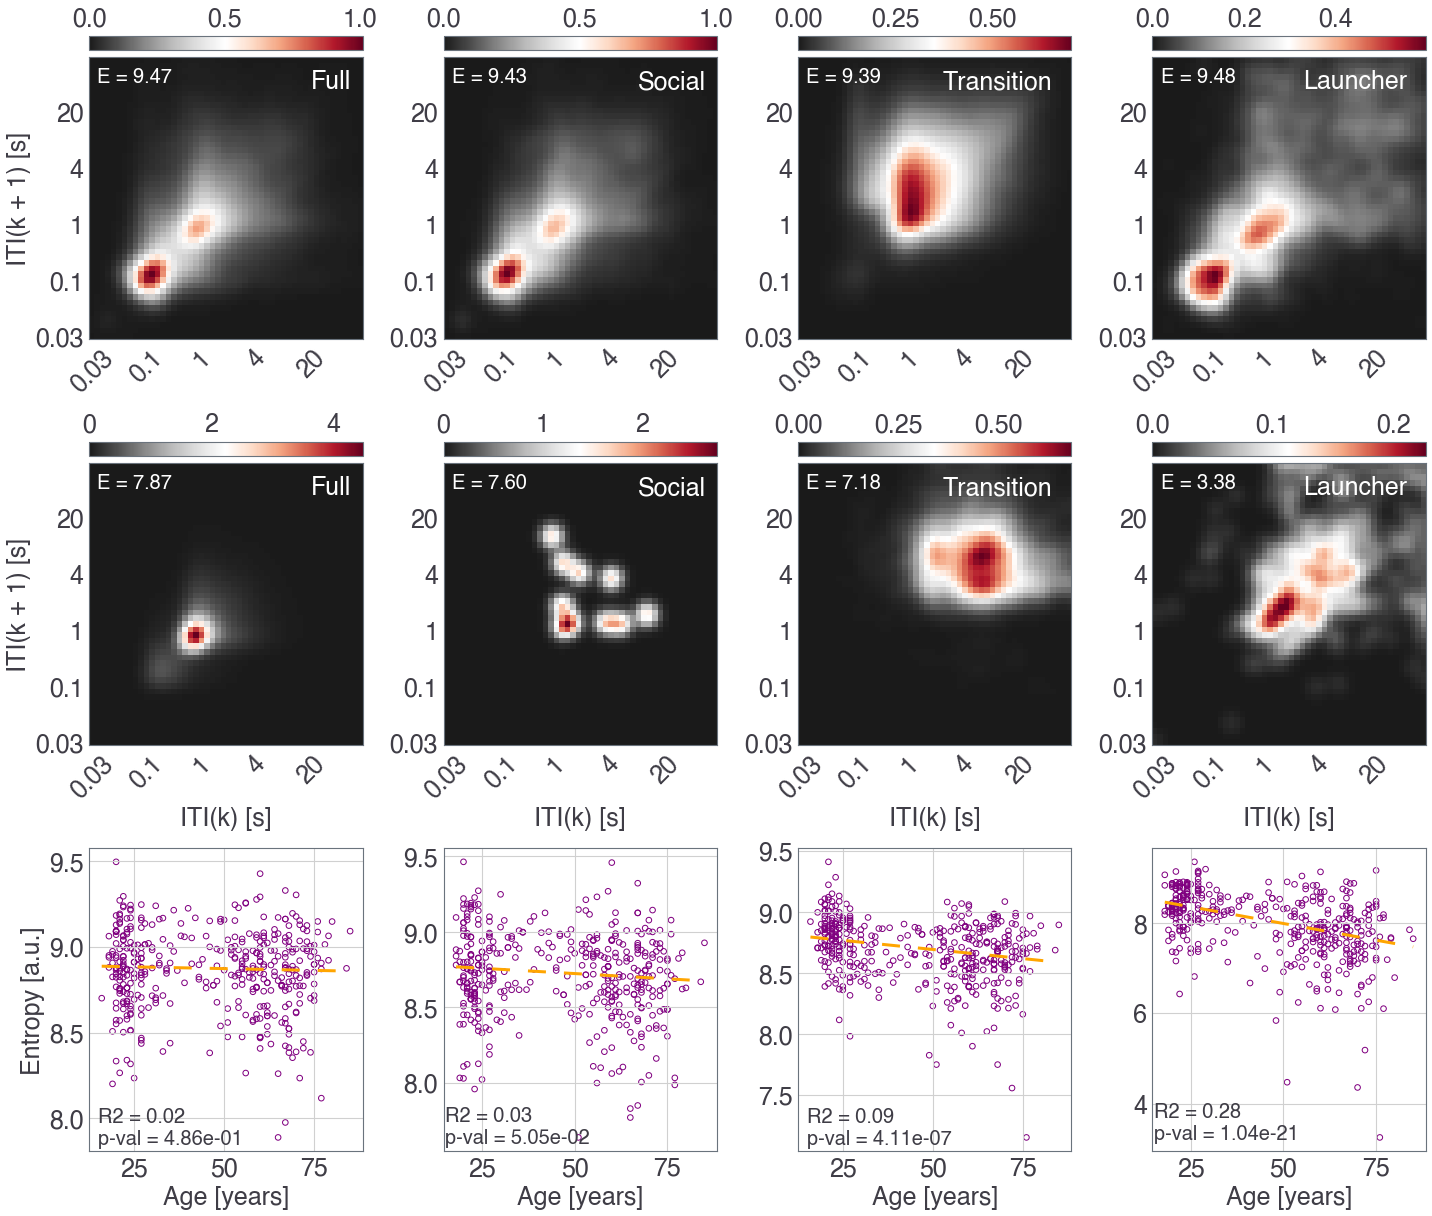

In [26]:
fig, ax = plt.subplots(3, 4, figsize=(20, 17))

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

vmin = np.Inf
vmax = -np.Inf

for i in range(4):
    age_entropy = all_age_entropy[i].flat[0]
    adjusted_fit = age_entropy[0]
    adjusted_data = age_entropy[1]
    entropy = age_entropy[2]
    age = age_entropy[3]
    gender = age_entropy[4]
    allJIDs = age_entropy[5]
    r2 = age_entropy[7][0][0]
    pval = age_entropy[8][0][0]
    
    idx_max = np.argmax(entropy)
    idx_min = np.argmin(entropy)
    
    _jid_max = 10 ** allJIDs[idx_max].reshape(50, 50).T
    _jid_min = 10 ** allJIDs[idx_min].reshape(50, 50).T
    
    vmin = min(vmin, np.min(_jid_max))
    vmin = min(vmin, np.min(_jid_min))
    
    vmax = max(vmax, np.max(_jid_max))
    vmax = max(vmax, np.max(_jid_min))

for i, (_title, _ylim, x_bias) in enumerate(zip(['Full', 'Social', 'Transition', 'Launcher'], [7.85, 7.6, 7.1, 3.2], [40, 35, 26, 27])):
    
    age_entropy = all_age_entropy[ORDER[i]].flat[0]
    adjusted_fit = age_entropy[0]
    adjusted_data = age_entropy[1]
    entropy = age_entropy[2]
    age = age_entropy[3]
    gender = age_entropy[4]
    allJIDs = age_entropy[5]
    r2 = age_entropy[7][0][0]
    pval = age_entropy[8][0][0]
    
    idx_max = np.argmax(entropy)
    idx_min = np.argmin(entropy)
    
    _jid_max = 10 ** allJIDs[idx_max].reshape(50, 50).T
    _jid_min = 10 ** allJIDs[idx_min].reshape(50, 50).T
    
    im = ax[0][i].imshow(_jid_max, aspect='auto', cmap='RdGy_r')
#     ax[0][i].set_title(f"{entropy[idx_max][0]:.2f}")
    ax[0][i].invert_yaxis()
    ax[0][i].set_xticks(ticks)
    ax[0][i].set_xticklabels(labels)
    ax[0][i].xaxis.set_tick_params(rotation=45)
    ax[0][i].set_yticks(ticks)
    ax[0][i].set_yticklabels(labels)
#     ax[0][i].set_xlabel('ITI(k) [s]')
    ax[0][i].grid(False)
    divider = make_axes_locatable(ax[0][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
    ax[0][i].text(x_bias, 44, f"{_title}", fontsize=25, color='white')
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    
    im = ax[1][i].imshow(_jid_min, aspect='auto', cmap='RdGy_r')
#     ax[1][i].set_title(f"{entropy[idx_min][0]:.2f}")
    ax[1][i].invert_yaxis()
    ax[1][i].set_xticks(ticks)
    ax[1][i].set_xticklabels(labels)
    ax[1][i].xaxis.set_tick_params(rotation=45)
    ax[1][i].set_yticks(ticks)
    ax[1][i].set_yticklabels(labels)
    ax[1][i].set_xlabel('ITI(k) [s]')
    ax[1][i].grid(False)
    divider = make_axes_locatable(ax[1][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
    ax[1][i].text(x_bias, 44, f"{_title}", fontsize=25, color='white')
    
    ax[0][i].text(1, 45, f"E = {entropy[idx_max][0]:.2f}", fontsize=20, color='white')
    ax[1][i].text(1, 45, f"E = {entropy[idx_min][0]:.2f}", fontsize=20, color='white')
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    
    
    ax[2][i].scatter(adjusted_data[0], adjusted_data[1], facecolors='none', edgecolors='purple', label='Subjects', linewidth=1)
    ax[2][i].plot(adjusted_fit[0], adjusted_fit[1], 'orange', dashes=[6, 6], linewidth=3, label="Linear Fit")
    ax[2][i].set_xlabel('Age [years]')
    ax[2][i].text(15, _ylim , f"R2 = {r2:.2f} \np-val = {pval:.2e}", fontsize=20)
    
ax[0][0].set_ylabel('ITI(k + 1) [s]')
ax[1][0].set_ylabel('ITI(k + 1) [s]')
ax[2][0].set_ylabel("Entropy [a.u.]")
plt.tight_layout()
plt.savefig('figure_1_supplementary_i.pdf', transparent=True)